# Evaluation

## Init

In [1]:
# general imports:
import os
import importlib
from torch import nn, cuda
from torch import optim
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

# my imports (reload all modules):

from data.dataset import load_data_deep_crack
from models.unet_resnet34 import UNetResNet34
from models.unet_swin import UNetSwin
from models.unet import UNet
from training.metrics import DiceLoss
from training.metrics import evaluate_dice_index
from training.train import train
from utils import count_trainable_parameters
from utils import to_4_significant_digits
from utils import generate_latex_table_thesis
from plotting import plot_image_mask_prediction_grid
from plotting import plot_image_mask_prediction_grid_with_dice


import data.dataset
import models.unet_resnet34
import models.unet_swin
import models.unet
import training.metrics
import training.train
import utils
import plotting

importlib.reload(data.dataset)
importlib.reload(models.unet_resnet34)
importlib.reload(models.unet_swin)
importlib.reload(models.unet)
importlib.reload(training.metrics)
importlib.reload(training.train)
importlib.reload(utils)
importlib.reload(plotting)

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
print(f'Number of visible CUDA devices: {cuda.device_count()}')
cuda.is_available()
# NOTE: when referring to a CUDA device, torch will only know about visible devices
#       so while currently we will be using gpu05
#       this will be device `cuda:0`

# LOAD THE DATA
data_source ='../../DeepCrack/dataset/DeepCrack'
train_image_dir = data_source + '/train_img'
train_mask_dir = data_source + '/train_lab'
test_image_dir = data_source + '/test_img'
test_mask_dir = data_source + '/test_lab'
train_dl, val_dl, train_dataset, val_dataset = load_data_deep_crack(train_image_dir, train_mask_dir, [0.8, 0.2], limit_im_nr=10)
# use validation to avoid augmentation
_, test_dl, _, test_dataset = load_data_deep_crack(test_image_dir, test_mask_dir, [0, 1])

c:\Users\Csaba\miniconda3\envs\cenv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Csaba\miniconda3\envs\cenv2\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Number of visible CUDA devices: 1
This gives us 240 train and 60 validation samples.
This gives us 0 train and 237 validation samples.


c:\Users\Csaba\miniconda3\envs\cenv2\Lib\site-packages\torch\utils\data\dataset.py:473: UserWarning: Length of split at index 0 is 0. This might result in an empty dataset.
  warnings.warn(


## UNET

## UNET all

In [2]:
import numpy as np
import torch
from tqdm import tqdm

# List of model subdirectories
path_list = ['unet_4', 'resnet_unfreeze2_2', 'swin_2']
learning_rates = [ "1e-3", "1e-5", "1e-3"]
started_from_models = [ "none", "resnet-1", "none"]
names = [ "unet-4", "resnet-1-2", "swin-1"]
epochs = [100, 100, 220]

models_list = [
    UNet(img_channels= 3, mask_channels= 1, base_channel_size= 32, depth= 5),
    UNetResNet34(img_channels = 3, mask_channels = 1, base_channel_size = 64),
    UNetSwin(img_channels = 3, mask_channels = 1, base_channel_size = 64)
]

# A list to store all evaluation results for later processing
results = []

# Iterate through all models and evaluate
for idx, path in enumerate(path_list, 1):
    print(f"\nProcessing model: {idx}/{len(path_list)} ({path})")

    # Initialize model and loss function
    model = models_list[idx-1]
    loss_fn = DiceLoss()

    # Load model training statistics
    model_dir = f'../saved_models/{path}'
    dice_idcs = list(np.load(f'{model_dir}/dice_idcs.npy'))
    epoch_dice_idcs = list(np.load(f'{model_dir}/epoch_dice_idcs.npy'))
    val_dice_idcs = list(np.load(f'{model_dir}/val_dice_idcs.npy'))
    train_loss = list(np.load(f'{model_dir}/train_loss.npy'))
    val_loss = list(np.load(f'{model_dir}/val_loss.npy'))
    epoch_durations = list(np.load(f'{model_dir}/epoch_durations.npy'))

    # Load best weights
    model.load_state_dict(torch.load(f'{model_dir}/best_model_wts.pth', weights_only=True))
    model.eval().cuda()

    # Evaluate on test set
    avg_score, score_list, preds = evaluate_dice_index(model, test_dataset)

    # Store everything in a dictionary
    result_entry = {
        "name": names[idx-1],
        "dice_idcs": dice_idcs,
        "epoch_dice_idcs": epoch_dice_idcs,
        "val_dice_idcs": val_dice_idcs,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "epoch_durations" :epoch_durations,
        "test_avg_dice": avg_score,
        "test_dice_scores": score_list,
        "test_predictions": preds,
        "number_of_params": count_trainable_parameters(model),
        "epoch_nr": epochs[idx-1],
        "lr": learning_rates[idx-1],
        "started_from": started_from_models[idx-1]
    }

    # Append results
    results.append(result_entry)

# Optional: convert to DataFrame if you don’t need preds
# import pandas as pd
# df_results = pd.DataFrame([{k: v for k, v in r.items() if k != 'test_predictions'} for r in results])

print("\nAll models processed.")


c:\Users\Csaba\miniconda3\envs\cenv2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Csaba\miniconda3\envs\cenv2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Processing model: 1/3 (unet_4)


c:\Users\Csaba\miniconda3\envs\cenv2\Lib\site-packages\torch\nn\modules\conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv2d(



Processing model: 2/3 (resnet_unfreeze2_2)

Processing model: 3/3 (swin_2)

All models processed.


0.13922619024912516


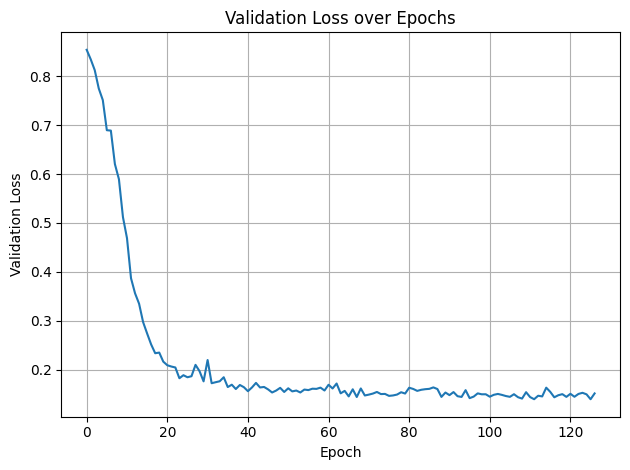

In [69]:
val_loss = list(np.load(f'{'../saved_models/resnet_unfreeze_again_1'}/val_loss.npy'))
print(min(val_loss))
# Plotting
plt.plot(val_loss)
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

In [66]:

min_index = val_loss.index(min(val_loss))
val_loss = val_loss[:min_index+1]
print(val_loss[-1])

0.13922619024912516


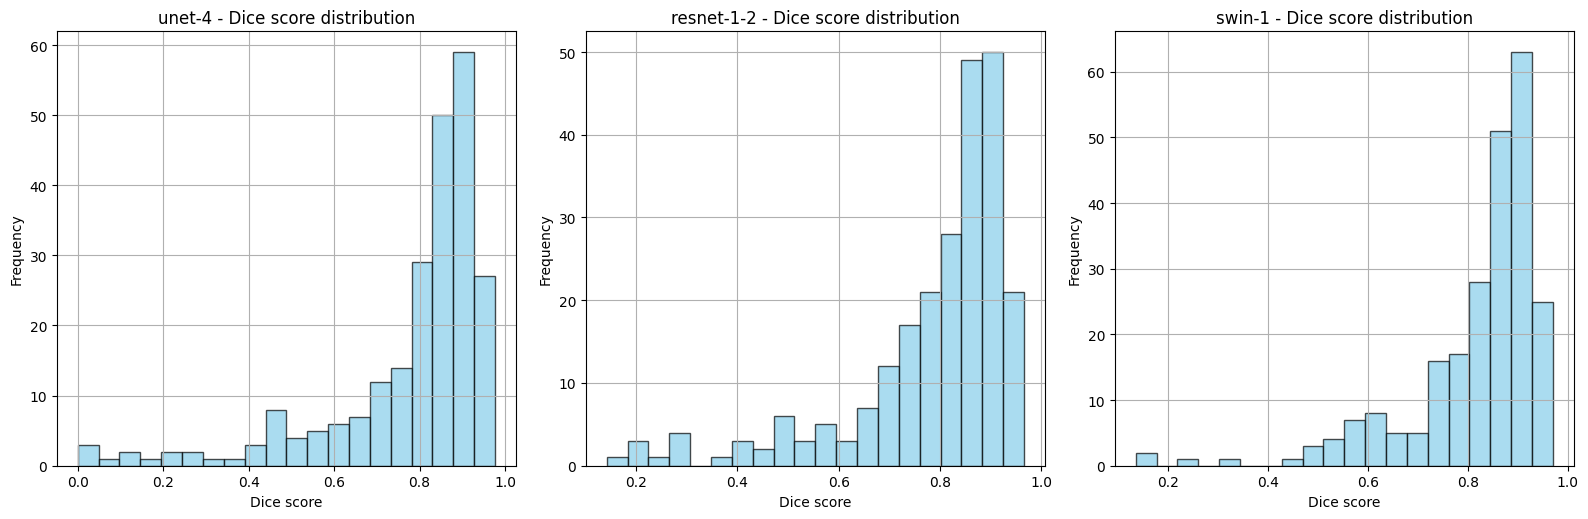

In [4]:
import matplotlib.pyplot as plt

# Set up the 2x2 subplot grid
fig, axs = plt.subplots(1, 3, figsize=(16, 5.3))
axs = axs.flatten()

# Plot histograms for the first 4 models
for i in range(3):
    res = results[i]
    ax = axs[i]
    
    ax.hist(res['test_dice_scores'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title(f"{res['name']} - Dice score distribution")
    ax.set_xlabel("Dice score")
    ax.set_ylabel("Frequency")
    ax.grid(True)

plt.tight_layout()
plt.savefig("../outputs/generated_figures/summary_dice_dist.png", dpi=300, bbox_inches='tight')
#plt.show()


In [5]:
# Prepare summary data
summary_data = []

for res in results:
    # Compute training time in hours
    total_seconds = sum(res.get("epoch_durations", []))
    training_time_hours = round(total_seconds / 3600, 3)

    # Build the row dictionary
    summary_data.append({
        "Name": res["name"],
        "Average Dice index": round(res["test_avg_dice"], 3),
        "Training time [hours]": training_time_hours
    })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)
generate_latex_table_thesis(summary_df, '../outputs/tables/summary_results.tex')
# Display the result
print(summary_df)

         Name  Average Dice index  Training time [hours]
0      unet-4               0.780                  2.213
1  resnet-1-2               0.786                  3.650
2      swin-1               0.819                 14.642


In [8]:
# Sort the scores and keep track of original indices
sorted_pairs = sorted(enumerate(val_loss), key=lambda x: x[1])

# Extract the sorted scores and their original indices
sorted_scores = [score for idx, score in sorted_pairs]
original_indices = [idx for idx, score in sorted_pairs]
print(original_indices)

[352, 276, 349, 257, 388, 351, 342, 275, 326, 319, 278, 251, 330, 301, 340, 343, 371, 389, 376, 333, 310, 345, 338, 339, 368, 258, 341, 238, 285, 332, 309, 350, 281, 328, 385, 348, 242, 355, 286, 354, 264, 303, 318, 312, 308, 336, 283, 279, 237, 398, 294, 396, 334, 202, 289, 297, 300, 169, 277, 337, 321, 374, 287, 320, 307, 346, 390, 298, 280, 269, 366, 296, 282, 325, 235, 245, 243, 267, 215, 240, 233, 302, 347, 236, 207, 386, 322, 178, 313, 196, 234, 316, 248, 214, 255, 266, 377, 194, 367, 344, 291, 364, 191, 293, 265, 209, 290, 393, 182, 288, 299, 228, 324, 292, 216, 378, 392, 199, 198, 220, 224, 262, 369, 387, 229, 218, 247, 263, 185, 210, 197, 254, 195, 373, 317, 362, 272, 370, 305, 227, 365, 219, 382, 384, 335, 239, 211, 295, 158, 274, 213, 205, 206, 363, 232, 244, 241, 311, 259, 223, 357, 284, 375, 212, 383, 187, 183, 304, 225, 380, 315, 221, 204, 164, 261, 391, 329, 201, 271, 372, 180, 167, 331, 381, 314, 268, 360, 353, 250, 399, 249, 397, 256, 252, 193, 155, 168, 179, 170, 192,

## Images

In [6]:
sorted_scores_list = []
original_indices_list= []
for i in range(3):
    preds = results[i]["test_predictions"]
    score_list = results[i]["test_dice_scores"]
    score_list_filtered = [x for x in score_list if x <= 0.15]

    # Sort the scores and keep track of original indices
    sorted_pairs = sorted(enumerate(score_list_filtered), key=lambda x: x[1])

    # Extract the sorted scores and their original indices
    sorted_scores = [score for idx, score in sorted_pairs]
    original_indices = [idx for idx, score in sorted_pairs]

    sorted_scores_list.append(sorted_scores)
    original_indices_list.append(original_indices)

In [7]:
sorted_scores_list = []
original_indices_list= []
for i in range(3):
    preds = results[i]["test_predictions"]
    score_list = results[i]["test_dice_scores"]

    # Sort the scores and keep track of original indices
    sorted_pairs = sorted(enumerate(score_list), key=lambda x: x[1])

    # Extract the sorted scores and their original indices
    sorted_scores = [score for idx, score in sorted_pairs]
    original_indices = [idx for idx, score in sorted_pairs]
    sorted_scores = np.array(sorted_scores)
    original_indices = np.array(original_indices)
    
    mask = sorted_scores < 0.6
    
    sorted_scores = sorted_scores[mask]
    original_indices = original_indices[mask]
    
    sorted_scores_list.append(sorted_scores)
    original_indices_list.append(original_indices)
    print(len(original_indices))

print(original_indices_list)

arrays = original_indices_list


# Step 1: Sort arrays by length (descending), while keeping original arrays
sorted_arrays = sorted(arrays, key=len, reverse=True)
#print(sorted_arrays)
for i, reference in enumerate(sorted_arrays):
    reference_set = set(reference)
    count = 0
    for j in range(i+1, len(sorted_arrays)):
        for x in sorted_arrays[j]:
            if x not in reference_set:
                count += 1
        print(f"The array nr. {j} has {count} items which are not in reference array nr. {i}. This is {count/len(sorted_arrays[j])*100} %")
        count = 0

35
29
21
[array([162, 124,  77,  36,  14,  81, 212, 166, 137, 165, 176, 143,  15,
        83, 103, 172, 195, 180, 127, 134, 160,  26, 144,  22,  40,  95,
         9,  11,  69, 126,  61,  54, 129, 119, 200]), array([ 36, 162,  77,  81, 124, 176,  14, 165, 212,  15, 180, 137, 166,
        40,  83, 143, 172, 103, 127, 130, 129,  26,  95, 144,  49,  22,
         1, 160,  54]), array([162,  36, 124, 212, 129, 165, 144,  81,  95, 176, 143,  77, 172,
       137, 166,  40, 180,  15, 160, 127,  83])]
The array nr. 1 has 3 items which are not in reference array nr. 0. This is 10.344827586206897 %
The array nr. 2 has 0 items which are not in reference array nr. 0. This is 0.0 %
The array nr. 2 has 0 items which are not in reference array nr. 1. This is 0.0 %


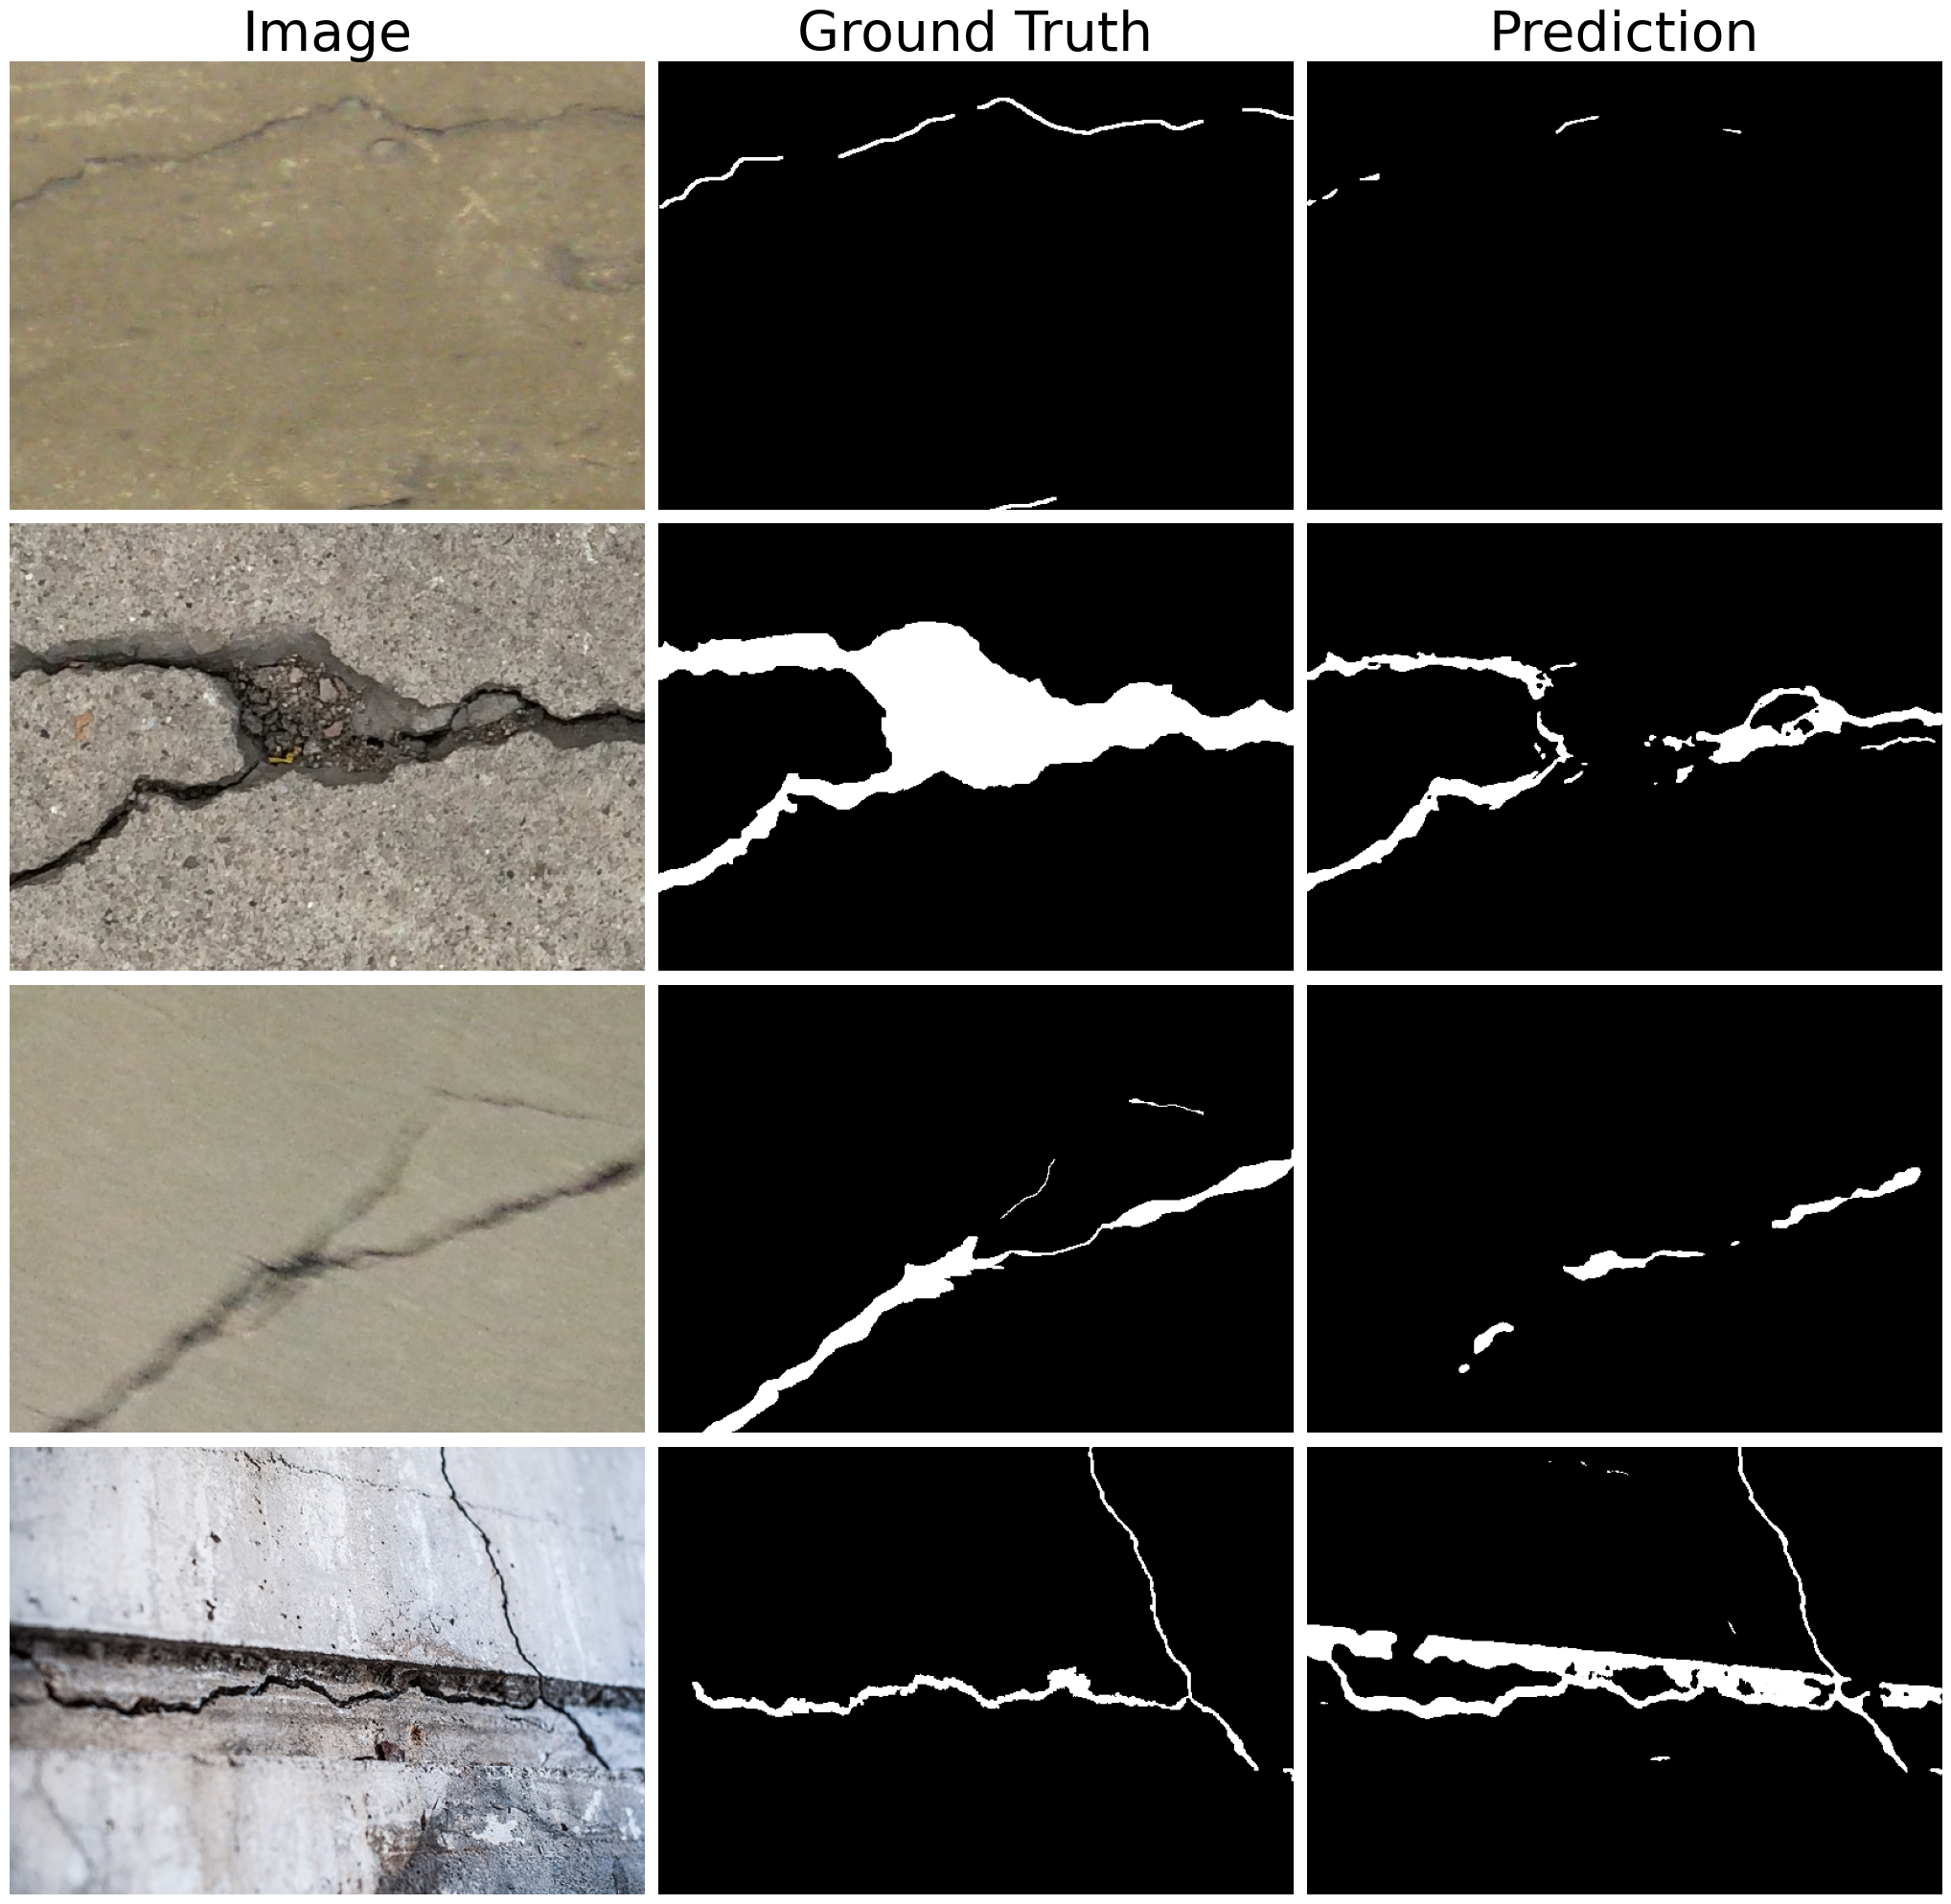

In [93]:
test_dataset.disable_transform()
images_to_list = original_indices[0:50]
triplets = []
indexes = [1, 4, 5, 6]
for i in indexes:
    # convert to orixinal index
    idx = images_to_list[i]
    pair = test_dataset.get_image_and_mask(idx)
    pred = preds[idx].cpu().numpy()
    triplets.append([pair[0], pair[1], pred])
plot_image_mask_prediction_grid(triplets, columns=1, scale = 20, path = "../outputs/generated_figures/difficult_images_examples.png")
#plot_image_mask_prediction_grid(triplets, columns=1, scale = 10)